# 02_06_legacywrap.ipynb - Wrapping legacy code with Cython, CFFI, and F2PY

In [36]:
import math
import numpy as np
import matplotlib.pyplot as pp

#### Code from 02_03_numpycompute.ipynb

In [37]:
def initphi(n=64):
    dx = 1/n
    xs = np.linspace(0.5*dx, 1-0.5*dx, n)
    
    phi = np.zeros((n,n), 'd')
    
    phi[:,-1] = np.sin(2 * math.pi * xs)
    phi[-1,:] = -np.sin(2 * math.pi * xs)
    
    return phi

In [38]:
def showphi(array, colorbar=True):
    pp.imshow(array.T, origin='lower', extent=(0,1,0,1),
              vmin=-1, vmax=1, cmap='coolwarm')
    
    if colorbar:
        pp.colorbar()

#### Wrapping C with Cython

In [59]:
%%file gauss_iterate.c

#define A(i,j) (array[(i)*nx + (j)])

void gauss_iterate(int nx, int ny, double *array, int iterations) {
    for(int k=0; k<iterations; k++) {
        for(int i=1; i<nx-1; i++) {
            for(int j=1; j<ny-1; j++) {
                A(i,j) = (A(i-1,j) + A(i+1,j) + A(i,j-1) + A(i,j+1)) / 4;
            }
        }
    }
}

Overwriting gauss_iterate.c


In [60]:
%%file gauss_iterate.h

void gauss_iterate(int nx, int ny, double *array, int iterations);

Overwriting gauss_iterate.h


In [61]:
%%file cgauss.pyx

# cython: language_level=3

cdef extern from "gauss_iterate.h":
    cdef void gauss_iterate(int nx, int ny, double array[], int iterations)

# it would be even safer to declare array with "double [:,::1]",
# which would accept only contiguous arrays

def gauss(double [:,:] array, int iterations):
    # array is a Cython "memoryview", but it supports numpy
    # operations such as obtaining its shape
    cdef int nx = array.shape[0], ny = array.shape[1]
    
    # call the C function, obtaining the address of the first array item
    gauss_iterate(nx, ny, &array[0,0], iterations)

Overwriting cgauss.pyx


In [62]:
%%file setup.py

from setuptools import setup, Extension
from Cython.Build import cythonize

ext_modules = [
    Extension("cgauss",
              sources=["cgauss.pyx", "gauss_iterate.c"],
              includes=["gauss_iterate.h"]
              )
]

setup(name="gauss",
      ext_modules=cythonize(ext_modules))

Overwriting setup.py


In [63]:
!python setup.py build_ext --inplace

/home/codespace/.local/lib/python3.12/site-packages/setuptools/_distutils/extension.py:150: UserWarning: Unknown Extension options: 'includes'
  warnings.warn(msg)
Compiling cgauss.pyx because it changed.
[1/1] Cythonizing cgauss.pyx
running build_ext
building 'cgauss' extension
gcc -fno-strict-overflow -Wsign-compare -DNDEBUG -g -O3 -Wall -fPIC -I/usr/local/python/3.12.1/include/python3.12 -c cgauss.c -o build/temp.linux-x86_64-cpython-312/cgauss.o
gcc -fno-strict-overflow -Wsign-compare -DNDEBUG -g -O3 -Wall -fPIC -I/usr/local/python/3.12.1/include/python3.12 -c gauss_iterate.c -o build/temp.linux-x86_64-cpython-312/gauss_iterate.o
gcc -shared build/temp.linux-x86_64-cpython-312/cgauss.o build/temp.linux-x86_64-cpython-312/gauss_iterate.o -o build/lib.linux-x86_64-cpython-312/cgauss.cpython-312-x86_64-linux-gnu.so
copying build/lib.linux-x86_64-cpython-312/cgauss.cpython-312-x86_64-linux-gnu.so -> 


In [64]:
import cgauss

In [65]:
cgauss.gauss

<cyfunction gauss at 0x7842fd64cac0>

In [66]:
phi = initphi(128)

In [67]:
cgauss.gauss(phi, 2000)

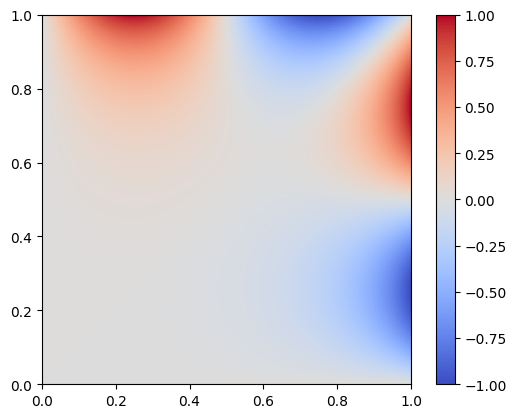

In [68]:
showphi(phi)

#### Wrapping C with CFFI

In [69]:
# on OS X or Linux (including WSL)
!gcc -I. gauss_iterate.c -shared -o gauss_iterate.so

In [70]:
# on Windows with Visual Studio 2019
# open the x64 Native Tools Command Prompt
# navigate to Ch02 folder

# cl /LD gauss_iterate.c

In [71]:
from cffi import FFI

In [72]:
ffi = FFI()

In [73]:
ffi.cdef("void gauss_iterate(int nx, int ny, double *array, int iterations);")

In [74]:
cfgauss = ffi.dlopen('./gauss_iterate.so')

# on Windows with Visual Studio 2019
# cfgauss = ffi.dlopen('gauss_iterate.dll')

In [75]:
cfgauss

<cffi.api._make_ffi_library.<locals>.FFILibrary at 0x7842decae2d0>

In [76]:
phi = initphi(128)

In [77]:
cfgauss.gauss_iterate(128, 128, ffi.cast("double *", phi.ctypes.data), 2000)

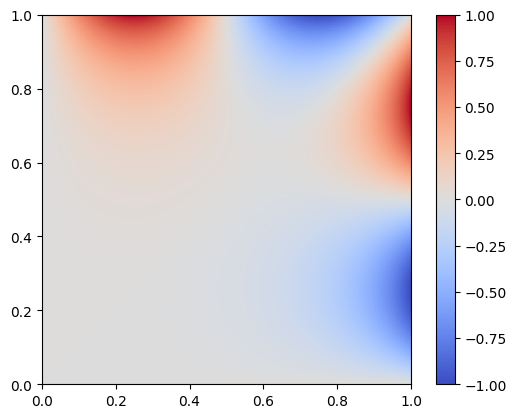

In [78]:
showphi(phi)

#### Wrapping Fortran with f2py

In [79]:
%%file gauss_iterate.f90

subroutine gauss(array,nx,ny,iterations)
    implicit none

    real*8, dimension(0:nx-1,0:ny-1), intent(inout) :: array
    integer, intent(in)                             :: nx,ny,iterations

    integer k,i,j
            
    do k=1,iterations
        do i=1,nx-2
            do j=1,ny-2
                array(i,j) = (array(i-1,j) + array(i+1,j) + array(i,j-1) + array(i,j+1)) / 4
            end do
        end do
    end do

    return
end subroutine gauss

Overwriting gauss_iterate.f90


In [86]:
!f2py -m fgauss -c gauss_iterate.f90

Cannot use distutils backend with Python>=3.12, using meson backend instead.
Using meson backend
Will pass --lower to f2py
See https://numpy.org/doc/stable/f2py/buildtools/meson.html
Reading fortran codes...
	Reading file 'gauss_iterate.f90' (format:free)
Post-processing...
	Block: fgauss
			Block: gauss
Applying post-processing hooks...
  character_backward_compatibility_hook
Post-processing (stage 2)...
Building modules...
    Building module "fgauss"...
    Generating possibly empty wrappers"
    Maybe empty "fgauss-f2pywrappers.f"
        Constructing wrapper function "gauss"...
          gauss(array,iterations,[nx,ny])
    Wrote C/API module "fgauss" to file "./fgaussmodule.c"
The Meson build system
Version: 1.8.2
Source dir: /tmp/tmp9x1n9u5e
Build dir: /tmp/tmp9x1n9u5e/bbdir
Build type: native build
Project name: fgauss
Project version: 0.1

meson.build:1:0: ERROR: Unknown compiler(s): [['gfortran'], ['flang-new'], ['flang'], ['nvfortran'], ['pgfortran'], ['ifort'], ['ifx'], ['g9

In [84]:
import fgauss

ModuleNotFoundError: No module named 'fgauss'

In [27]:
?fgauss.gauss

Object `fgauss.gauss` not found.


In [28]:
fphi = np.asfortranarray(initphi(128))

In [29]:
fgauss.gauss(fphi, 2000)

NameError: name 'fgauss' is not defined

In [ ]:
showphi(fphi)

#### Wrapping Fortran with fortran-magic

In [30]:
# !pip install fortran-magic
%load_ext fortranmagic

ModuleNotFoundError: No module named 'fortranmagic'

In [31]:
%%fortran

subroutine fgauss(array,nx,ny,iterations)
    implicit none

    real*8, dimension(0:nx-1,0:ny-1), intent(inout) :: array
    integer, intent(in)                             :: nx,ny,iterations

    integer k,i,j
            
    do k=1,iterations
        do i=1,nx-2
            do j=1,ny-2
                array(i,j) = (array(i-1,j) + array(i+1,j) + array(i,j-1) + array(i,j+1)) / 4
            end do
        end do
    end do

    return
end subroutine fgauss

UsageError: Cell magic `%%fortran` not found.


In [ ]:
fgauss

In [ ]:
?fgauss